INFO: Sample types derived from a single biological sample (will not show CI): {'Control'}
C
H1
H2
H3
K1
K2
K3
W1
W2
W3

📊 Plot saved as optical_density_growth_curves_revised.png


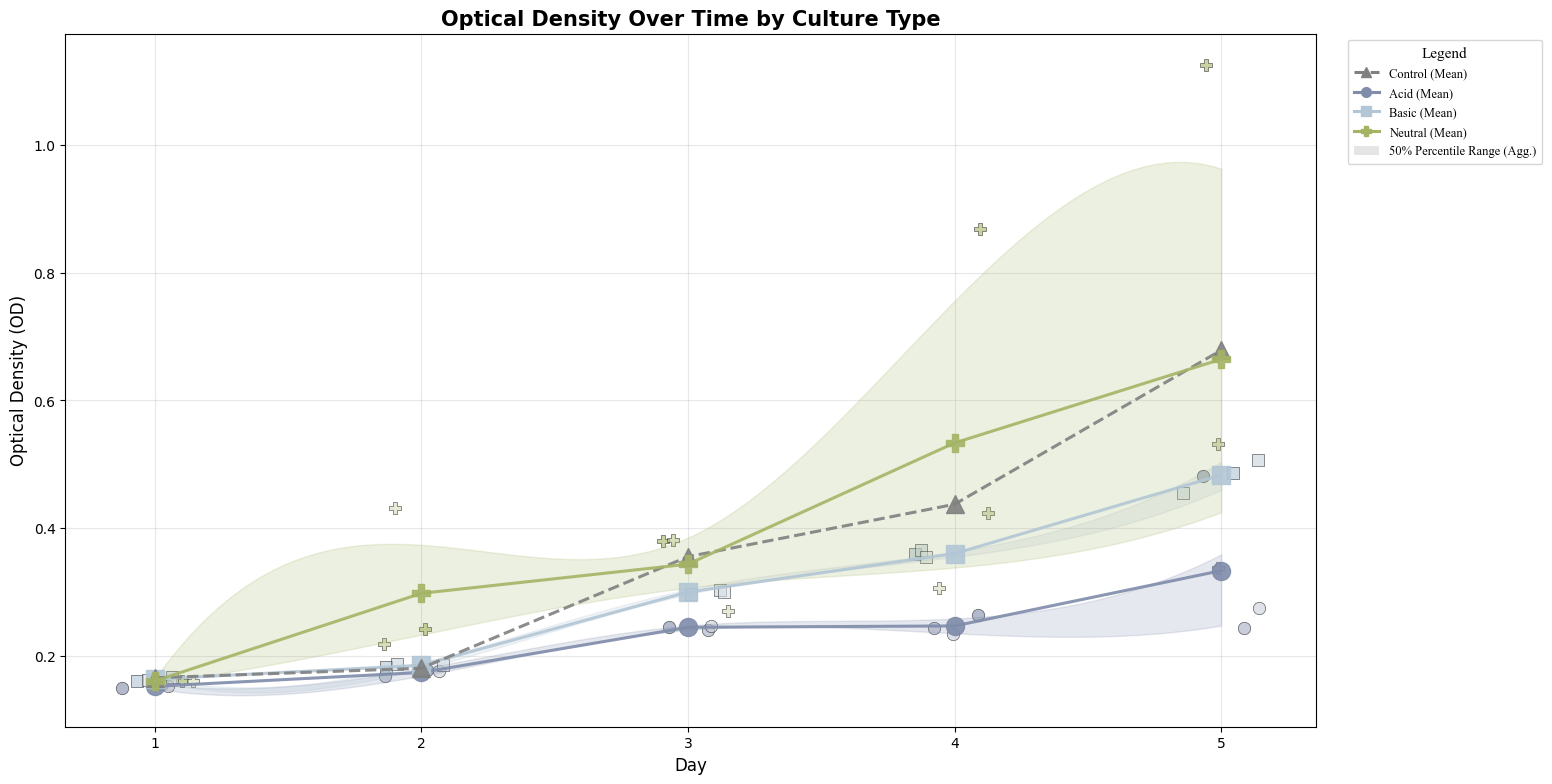

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns # For enhanced color palettes and aesthetics
from scipy.interpolate import make_interp_spline # For smoothing confidence intervals
from matplotlib.lines import Line2D # For creating custom legend elements
from matplotlib.patches import Patch # For creating custom legend patches

# --- Configuration Options ---
SHOW_INDIVIDUAL_SAMPLES = True
SHOW_AGGREGATED = True
SMOOTH_CONFIDENCE_INTERVALS = True
SHOW_95_CONFIDENCE = False
SHOW_50_CONFIDENCE = True # As per your image, 50% CI seems to be shown
SMOOTHING_POINTS = 100

# 1. Initial Data (from your first script)
measurements = {
    'K1':  [[0.147, 0.152], [0.17, 0.186], [0.239, 0.253], [0.265, 0.263], [0.582, 0.381]],
    'K2': [[0.154, 0.158], [0.167, 0.17], [0.237, 0.246], [0.241, 0.246], [0.243, 0.244]],
    'K3': [[0.148, 0.157], [0.169, 0.184], [0.247, 0.248], [0.234, 0.234], [0.259, 0.293]],
    'H1': [[0.158, 0.163], [0.238, 0.248], [0.369, 0.39], [0.866, 0.872], [1.145, 1.104]],
    'H2': [[0.159, 0.165], [0.207, 0.232], [0.374, 0.389], [0.425, 0.424], [0.524, 0.539]],
    'H3': [[0.156, 0.165], [0.448, 0.416], [0.255, 0.286], [0.31, 0.304], [0.283, 0.392]],
    'W1': [[0.156, 0.166], [0.184, 0.183], [0.298, 0.296], [0.355, 0.365], [0.458, 0.516]],
    'W2': [[0.169, 0.167], [0.178, 0.198], [0.305, 0.302], [0.372, 0.359], [0.468, 0.547]],
    'W3': [[0.161, 0.165], [0.179, 0.192], [0.287, 0.313], [0.355, 0.356], [0.445, 0.466]],
    'C': [[0.167, 0.165], [0.181, 0.181], [0.351, 0.36], [0.441, 0.434], [0.666, 0.691]]
}

# 2. Reshape Data into a Pandas DataFrame
data_for_df = []
for sample_name, days_data in measurements.items():
    for day_index, replicates in enumerate(days_data):
        day_num = day_index + 1
        for replicate_index, od_value in enumerate(replicates):
            replicate_num = replicate_index + 1
            data_for_df.append({
                'Sample': sample_name, 'Day': day_num,
                'Technical_Replicate': replicate_num, 'OD': od_value
            })
df_melted = pd.DataFrame(data_for_df)

# 3. Define Sample Types ("Sample_Type") and "Media"
def extract_sample_info(sample_name):
    if sample_name.startswith('K'): return 'Acid', 'Acid_Media'
    elif sample_name.startswith('H'): return 'Neutral', 'Neutral_Media'
    elif sample_name.startswith('W'): return 'Basic', 'Basic_Media'
    elif sample_name == 'C': return 'Control', 'Control_Media'
    else: return 'Other', 'Other_Media'
df_melted[['Sample_Type', 'Media']] = df_melted['Sample'].apply(lambda x: pd.Series(extract_sample_info(x)))
df_melted['Combined_Group'] = df_melted['Media'] + ' + ' + df_melted['Sample_Type']
df_melted['X_Axis_Time_Days'] = df_melted['Day']

# 4. Calculate Statistics for Individual Samples
sample_agg_funcs = {'OD_mean': ('OD', 'mean'), 'OD_std': ('OD', 'std'), 'OD_count': ('OD', 'count')}
df_sample_summary = df_melted.groupby(['Sample', 'Media', 'Sample_Type', 'X_Axis_Time_Days']).agg(**sample_agg_funcs).reset_index()
df_sample_summary['OD_std'] = df_sample_summary['OD_std'].fillna(0)

# 5. Calculate Statistics for Aggregated Groups
group_agg_funcs = {
    'OD_mean': ('OD', 'mean'), 'OD_std': ('OD', 'std'),
    'OD_p025': ('OD', lambda x: np.percentile(x, 2.5) if len(x) > 1 else x.iloc[0]),
    'OD_p975': ('OD', lambda x: np.percentile(x, 97.5) if len(x) > 1 else x.iloc[0]),
    'OD_p25': ('OD', lambda x: np.percentile(x, 25) if len(x) > 1 else x.iloc[0]),
    'OD_p75': ('OD', lambda x: np.percentile(x, 75) if len(x) > 1 else x.iloc[0]),
    'OD_count': ('OD', 'count')
}
df_group_summary = df_melted.groupby(['Combined_Group', 'Media', 'Sample_Type', 'X_Axis_Time_Days']).agg(**group_agg_funcs).reset_index()

# 6. Plotting Setup
# plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(18, 9))


# Publication-ready style
# sns.set_style("whitegrid")

# plt.rcParams.update({
#     'axes.titlesize': 18,       # plot title
#     'axes.labelsize': 16,       # x and y labels
#     'xtick.labelsize': 14,      # x tick labels
#     'ytick.labelsize': 14,      # y tick labels
#     'legend.fontsize': 13,      # legend text
#     'legend.title_fontsize': 14, # legend title
#     'font.family': 'Times New Roman'
# })

# sample_type_base_colors = {
#     'Acid': '#1b5e20',      # deep kelp green
#     'Neutral': '#2e7d32',   # fresh algae green
#     'Basic': '#66bb6a',     # lighter seaweed green
#     'Control': '#a5d6a7'    # pale green foam
# }

sample_type_base_colors = {
    'Acid': '#7F8CAA', 
    'Neutral': '#A4B465', 
    'Basic': '#B2C6D5', 
    'Control': '#808080'
}
group_types_unique = df_melted['Combined_Group'].unique()
group_color_map = {cg: sample_type_base_colors[cg.split(' + ')[1]] for cg in group_types_unique}
# print(group_color_map)
# group_color_map = {'Control_Media + Control': (float(156 / 255), float(175 / 255), float(170 / 255)),
#                    'Basic_Media + Basic': (float(69 / 255), float(104 / 255), float(130 / 255)),
#                    'Neutral_Media + Neutral': (float(202 / 255), float(220 / 255), float(174 / 255)),
#                    'Acid_Media + Acid': (float(214 / 255), float(169 / 255), float(157 / 255)),
#                    }

# rgb(202, 220, 174)
# rgb(214, 169, 157)
# rgb(69, 104, 130)

# {'Acid_Media + Acid': '#3E5F44', 'Neutral_Media + Neutral': '#4A9782', 'Basic_Media + Basic': '#A3DC9A', 'Control_Media + Control': '#000000'}




samples_unique = df_melted['Sample'].unique()
sample_color_map = {}
for s_type, base_color_hex in sample_type_base_colors.items():
    current_samples_in_type = [s for s in samples_unique if extract_sample_info(s)[0] == s_type]
    if len(current_samples_in_type) > 0:
        if len(current_samples_in_type) == 1: palette = [base_color_hex]
        elif len(current_samples_in_type) == 2: palette = sns.color_palette([sns.desaturate(base_color_hex, 0.2), sns.saturate(base_color_hex, 0.2)])
        else: palette = sns.light_palette(base_color_hex, n_colors=len(current_samples_in_type) + 1, reverse=True)[:-1]
        for i, sample_name in enumerate(current_samples_in_type): sample_color_map[sample_name] = palette[i % len(palette)]

unique_media_types = sorted(list(df_melted['Media'].unique()))
available_markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v']
marker_map = {media: available_markers[i % len(available_markers)] for i, media in enumerate(unique_media_types)}

def create_smooth_line(x, y, num_points=SMOOTHING_POINTS):
    x_original_data, y_original_data = np.array(x), np.array(y)
    sort_indices = np.argsort(x_original_data)
    x_sorted, y_sorted = x_original_data[sort_indices], y_original_data[sort_indices]
    if len(x_sorted) > 2 and SMOOTH_CONFIDENCE_INTERVALS:
        x_unique, unique_indices = np.unique(x_sorted, return_index=True)
        y_unique = y_sorted[unique_indices]
        if len(x_unique) < 2: return x_sorted, y_sorted
        k_spline = min(3, len(x_unique) - 1)
        if k_spline < 1: return x_sorted, y_sorted
        x_new = np.linspace(min(x_unique), max(x_unique), num_points)
        try:
            spl = make_interp_spline(x_unique, y_unique, k=k_spline)
            return x_new, spl(x_new)
        except Exception: return x_sorted, y_sorted
    return x_sorted, y_sorted

# --- Determine which Sample_Types are based on a single biological sample ---
single_sample_types = set()
if 'Sample_Type' in df_melted.columns and 'Sample' in df_melted.columns:
    for s_type_name in df_melted['Sample_Type'].unique():
        num_unique_samples = df_melted[df_melted['Sample_Type'] == s_type_name]['Sample'].nunique()
        if num_unique_samples == 1:
            single_sample_types.add(s_type_name)
print(f"INFO: Sample types derived from a single biological sample (will not show CI): {single_sample_types}")

# --- Plotting Individual Sample Trajectories ---


def jitter(arr, jitter_amount=0.05):
    return arr + np.random.uniform(-jitter_amount, jitter_amount, size=len(arr))
if SHOW_INDIVIDUAL_SAMPLES:

    for sample_name, sample_data in df_sample_summary.groupby('Sample'):
        print(sample_name)
        if sample_name == 'C':
            continue
    #     sample_type = sample_data['Sample_Type'].iloc[0]
    #     media = sample_data['Media'].iloc[0]
    #     combined_group = f"{media} + {sample_type}"

    #     color = sample_color_map.get(sample_name, group_color_map.get(combined_group, 'gray'))

        sample_data = sample_data.sort_values('X_Axis_Time_Days')
        color, media = sample_color_map.get(sample_name, 'grey'), sample_data['Media'].iloc[0]
        marker=marker_map.get(media, 'o')
        # marker = marker_map.get(combined_group, 'o')

        # x_orig = sample_data['X_Axis_Time_Days'].values
        # y_orig = sample_data['OD'].values

        x_orig, y_orig = sample_data['X_Axis_Time_Days'], sample_data['OD_mean']

        x_jittered = jitter(x_orig, jitter_amount=0.15)

        plt.scatter(x_jittered, y_orig, 
                    color=color, marker=marker, alpha=0.6, s=80, 
                    edgecolors='k', linewidths=0.5, label=None)
    # # for sample_name, sample_data in df_sample_summary.groupby('Sample'):
    #     # linestyle = '--' if sample_name == 'C' else '-'
    #     plt.errorbar(sample_data['X_Axis_Time_Days'], sample_data['OD_mean'], yerr=sample_data['OD_std'],
    #                  label=sample_name, color=color, marker=marker_map.get(media, 'o'),
    #                  markersize=5, linestyle=linestyle, linewidth=1.2, elinewidth=1, capsize=3, alpha=0.8)

# --- Plotting Aggregated Group Trajectories ---
if SHOW_AGGREGATED:
    for group_name, group_data in df_group_summary.groupby('Combined_Group'):
        group_data = group_data.sort_values('X_Axis_Time_Days')
        base_sample_type, current_media = group_data['Sample_Type'].iloc[0], group_data['Media'].iloc[0]
        color = group_color_map[group_name]
        linestyle = '--' if base_sample_type == 'Control' else '-'
        x_values, y_mean = group_data['X_Axis_Time_Days'].values, group_data['OD_mean'].values

        plt.plot(x_values, y_mean, label=f"{base_sample_type}", color=color,
                 marker=marker_map.get(current_media, 'o'), markersize=13, linestyle=linestyle, linewidth=2.2, alpha=0.9)

        # --- MODIFIED: Conditional plotting of Confidence Intervals ---
        # Only plot CIs if the group is NOT a single-sample type and data is sufficient
        if base_sample_type not in single_sample_types and len(x_values) > 1:
            y_p025, y_p975 = group_data['OD_p025'].values, group_data['OD_p975'].values
            y_p25, y_p75 = group_data['OD_p25'].values, group_data['OD_p75'].values

            if SHOW_95_CONFIDENCE:
                # Only draw if the interval has some width (lower/upper bounds are different)
                if not np.allclose(y_p025, y_p975, atol=1e-4): # Using a small tolerance
                    x_smooth_95, lower_95 = create_smooth_line(x_values, y_p025)
                    _, upper_95 = create_smooth_line(x_values, y_p975)
                    plt.fill_between(x_smooth_95, lower_95, upper_95, color=color, alpha=0.1, label=None)
            
            if SHOW_50_CONFIDENCE:
                if not np.allclose(y_p25, y_p75, atol=1e-4): # Using a small tolerance
                    x_smooth_50, lower_50 = create_smooth_line(x_values, y_p25)
                    _, upper_50 = create_smooth_line(x_values, y_p75)
                    plt.fill_between(x_smooth_50, lower_50, upper_50, color=color, alpha=0.2, label=None)
        # Optional: print a message if CIs are skipped for a group
        # elif base_sample_type in single_sample_types and (SHOW_95_CONFIDENCE or SHOW_50_CONFIDENCE):
        # print(f"DEBUG: Skipped CI for single-sample group: {base_sample_type}")

plt.rcParams['font.family'] = 'Times New Roman'

# --- Final Plot Touches ---
plt.title('', fontsize=15, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Optical Density (OD)', fontsize=12)
plt.xticks(sorted(df_melted['X_Axis_Time_Days'].unique()), fontsize=10)
plt.yticks(fontsize=10)

# --- Custom Legend ---
legend_elements = []
sorted_samples_for_legend = sorted(list(samples_unique), key=lambda s: (extract_sample_info(s)[0] != 'Control', extract_sample_info(s)[0], s))
# if SHOW_INDIVIDUAL_SAMPLES:

        
#     for sample_name in sorted_samples_for_legend:
#         media, color = df_sample_summary[df_sample_summary['Sample'] == sample_name]['Media'].iloc[0], sample_color_map.get(sample_name, 'grey')
#         linestyle = '--' if sample_name == 'C' else '-'
#         legend_elements.append(Line2D([0], [0], color=color, marker=marker_map.get(media, 'o'), linestyle=linestyle, markersize=5, linewidth=1.2, label=sample_name))

sorted_group_types_for_legend = sorted(list(group_types_unique), key=lambda cg: (cg.split(' + ')[1] != 'Control', cg.split(' + ')[1]))
if SHOW_AGGREGATED:
    for group_name in sorted_group_types_for_legend:
        base_sample_type, current_media = group_name.split(' + ')[1], group_name.split(' + ')[0]
        color = group_color_map[group_name]
        linestyle = '--' if base_sample_type == 'Control' else '-'
        legend_elements.append(Line2D([0], [0], color=color, marker=marker_map.get(current_media, 'o'), linestyle=linestyle, markersize=7, linewidth=2.2, label=f"{base_sample_type} (Mean)"))

# Add CI legend entries only if CIs are actually shown for any multi-sample group
any_multisample_group_showed_ci = False
if SHOW_AGGREGATED:
    for group_name in sorted_group_types_for_legend:
        base_sample_type = group_name.split(' + ')[1]
        if base_sample_type not in single_sample_types:
            any_multisample_group_showed_ci = True
            break

if any_multisample_group_showed_ci and (SHOW_50_CONFIDENCE or SHOW_95_CONFIDENCE):
    representative_patch_color = 'darkgrey'
    if SHOW_50_CONFIDENCE: legend_elements.append(Patch(facecolor=representative_patch_color, alpha=0.3, label='50% Percentile Range (Agg.)'))
    if SHOW_95_CONFIDENCE: legend_elements.append(Patch(facecolor=representative_patch_color, alpha=0.15, label='95% Percentile Range (Agg.)'))

if legend_elements:
    ncol_legend = 1
    if len(legend_elements) > 8: ncol_legend = 2
    if len(legend_elements) > 16: ncol_legend = 3
    plt.legend(handles=legend_elements, title='Legend', title_fontsize='11', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='9', ncol=ncol_legend, frameon=True, borderpad=0.5, labelspacing=0.6)
    plt.subplots_adjust(right=0.78 if ncol_legend > 1 else 0.82)
else: plt.tight_layout()


plt.grid(True, alpha=0.3)
plot_filename = "optical_density_growth_curves_revised.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"\n📊 Plot saved as {plot_filename}")
plt.show()
